In [152]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import sklearn
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
import os
import numpy as np
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from pprint import pprint

## Look into stats tests between the rainfall and month

In [56]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [57]:
df.columns=df.columns.str.lower()

In [58]:
df.isnull().sum()

date                 0
location             0
mintemp            637
maxtemp            322
rainfall          1406
evaporation      60843
sunshine         67816
windgustdir       9330
windgustspeed     9270
winddir9am       10013
winddir3pm        3778
windspeed9am      1348
windspeed3pm      2630
humidity9am       1774
humidity3pm       3610
pressure9am      14014
pressure3pm      13981
cloud9am         53657
cloud3pm         57094
temp9am            904
temp3pm           2726
raintoday         1406
risk_mm              0
raintomorrow         0
dtype: int64

In [59]:
# Gives me a percentage missing in the data
# Looking at some big values that make me think two things
## One, impute the value somehow
## Two, drop them entirely, and be happy with hopefully 50,000 data points
pd.Series(df.isnull().sum().values/len(df), index=df.columns)

date             0.000000
location         0.000000
mintemp          0.004480
maxtemp          0.002265
rainfall         0.009888
evaporation      0.427890
sunshine         0.476929
windgustdir      0.065615
windgustspeed    0.065193
winddir9am       0.070418
winddir3pm       0.026570
windspeed9am     0.009480
windspeed3pm     0.018496
humidity9am      0.012476
humidity3pm      0.025388
pressure9am      0.098556
pressure3pm      0.098324
cloud9am         0.377353
cloud3pm         0.401525
temp9am          0.006358
temp3pm          0.019171
raintoday        0.009888
risk_mm          0.000000
raintomorrow     0.000000
dtype: float64

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
date             142193 non-null object
location         142193 non-null object
mintemp          141556 non-null float64
maxtemp          141871 non-null float64
rainfall         140787 non-null float64
evaporation      81350 non-null float64
sunshine         74377 non-null float64
windgustdir      132863 non-null object
windgustspeed    132923 non-null float64
winddir9am       132180 non-null object
winddir3pm       138415 non-null object
windspeed9am     140845 non-null float64
windspeed3pm     139563 non-null float64
humidity9am      140419 non-null float64
humidity3pm      138583 non-null float64
pressure9am      128179 non-null float64
pressure3pm      128212 non-null float64
cloud9am         88536 non-null float64
cloud3pm         85099 non-null float64
temp9am          141289 non-null float64
temp3pm          139467 non-null float64
raintoday        140787 non-null obje

`evaporation` is probably going to be really necessary to predict. My thinking of replacing it might skew the data. However, since I don't know which is more important (`pressure, sunshine, humidity, clouds`) I need to come up with a solution.  
I think it could be worth while to simply drop all of the null values, maybe that messes the data up, but then I could get a rough correlation matrix and see what is and isn't important, then clean the data around that.

In [61]:
# Saving an original form of the data as df
# Active set will be df_test

df_test = df
df_test.dropna(inplace=True)
df_test.shape

(56420, 24)

In [62]:
df['location'].value_counts().keys()

Index(['Darwin', 'Perth', 'Brisbane', 'MelbourneAirport', 'PerthAirport',
       'SydneyAirport', 'Watsonia', 'Mildura', 'MountGambier', 'NorfolkIsland',
       'Cairns', 'Townsville', 'WaggaWagga', 'AliceSprings', 'Nuriootpa',
       'Hobart', 'Moree', 'Melbourne', 'Portland', 'Woomera', 'Sydney', 'Sale',
       'CoffsHarbour', 'Williamtown', 'Canberra', 'Cobar'],
      dtype='object')

And would you look at that!!! I correctly assumed I would have around 50k datapoints....

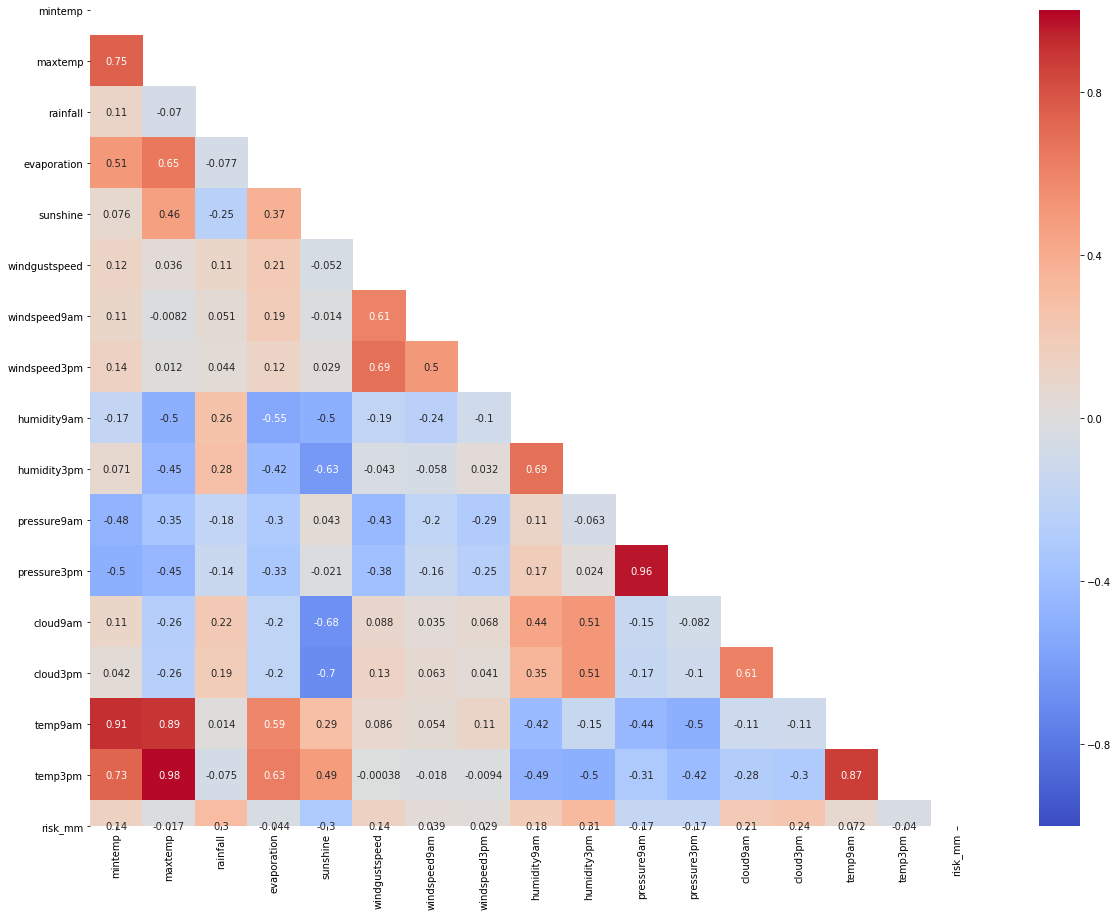

In [63]:
# Looking at the correlation matrix and seeing what interacts etc...
f, ax = plt.subplots(figsize=(20, 15))
matrix = np.triu(df_test.corr())
sns.heatmap(df_test.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

The target variable wasn't included because it currently is a `Yes/No` format.  
Need to map the columns with `Yes/No` to a binary `0/1` layout.  
In addition, all of the `wind` variables need dummies, `raintoday` and `location`

In [64]:
# Dropping `risk_mm` because it was originally used to create the binary for the next day of whether it rained or not
df_test.drop(columns=['risk_mm'], inplace=True)

Keep in mind that Australia is in the other hemisphere. The seasons are reversed. What I am going to do is change the `date` to `season` and change the values to one of the four seasons then dummy them.

In [65]:
df_test.reset_index(drop=True, inplace=True)

In [66]:
type(df_test['date'][0])

str

The data type is string and that could work. The best way I can think of going about this is to remove all of the years and days from the date and then make a map statement saying to put in place a `season` for certain strings.

In [67]:
dates = df_test['date'].map(lambda x: x[5:7])

In [68]:
df_test['dates'] = dates

In [69]:
df_test.drop(columns=['date'], inplace=True)

In [70]:
df_test['season'] = df_test['dates'].map({'01': 'summer', '02': 'summer', '12': 'summer', 
                                         '03': 'autumn', '04': 'autumn', '05': 'autumn',
                                         '06': 'winter', '07': 'winter', '08': 'winter',
                                         '09': 'spring', '10': 'spring', '11': 'spring'})

In [71]:
df_test.head()

,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,dates,season
0,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,01,summer
1,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,01,summer
2,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,01,summer
3,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,01,summer
4,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,WNW,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No,01,summer


In [72]:
df_test.drop(columns=['dates'], inplace=True)

In [73]:
df_test['raintomorrow'] = df_test['raintomorrow'].map({'No': '0', 'Yes': '1'})

In [74]:
df_test.head()

,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,season
0,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,0,summer
1,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,0,summer
2,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,0,summer
3,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,0,summer
4,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,WNW,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,0,summer


In [75]:
df_test['raintomorrow'] = df_test['raintomorrow'].astype(int)

In [76]:
df_test

,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,season
0,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,0,summer
1,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,0,summer
2,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,0,summer
3,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,0,summer
4,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,WNW,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,0,summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56415,Darwin,19.3,33.4,0.0,6.0,11.0,ENE,35.0,SE,NE,9.0,20.0,63.0,32.0,1013.9,1010.5,0.0,1.0,24.5,32.3,No,0,winter
56416,Darwin,21.2,32.6,0.0,7.6,8.6,E,37.0,SE,SE,13.0,11.0,56.0,28.0,1014.6,1011.2,7.0,0.0,24.8,32.0,No,0,winter
56417,Darwin,20.7,32.8,0.0,5.6,11.0,E,33.0,E,W,17.0,11.0,46.0,23.0,1015.3,1011.8,0.0,0.0,24.8,32.1,No,0,winter
56418,Darwin,19.5,31.8,0.0,6.2,10.6,ESE,26.0,SE,NNW,9.0,17.0,62.0,58.0,1014.9,1010.7,1.0,1.0,24.8,29.2,No,0,winter


Still need to dummy variable: `location, winds, seasons`  
Still need to binary `raintoday`

In [77]:
df_test['raintoday'] = df_test['raintoday'].map({'No': '0', 'Yes': '1'})
df_test['raintoday'] = df_test['raintoday'].astype(int)

In [78]:
df_test['winddir9am'] = df_test['winddir9am'].map({'ENE': 'NE', 'SSE': 'SE', 'SE':'SE', 'ESE':'SE', 'NNE':'NE',
                           'WSW':'SW', 'NNW':'NW', 'SSW':'SW', 'WNW':'NW',
                           'N':'N', 'E':'E', 'S':'S', 'W':'W', 'SW': 'SW',
                           'NW':'NW', 'SE':'SE', 'NE':'NE'
                          })
df_test['winddir3pm'] = df_test['winddir3pm'].map({'ENE': 'NE', 'SSE': 'SE', 'SE':'SE', 'ESE':'SE', 'NNE':'NE',
                           'WSW':'SW', 'NNW':'NW', 'SSW':'SW', 'WNW':'NW',
                           'N':'N', 'E':'E', 'S':'S', 'W':'W', 'SW': 'SW',
                           'NW':'NW', 'SE':'SE', 'NE':'NE'
                          })
df_test['windgustdir'] = df_test['windgustdir'].map({'ENE': 'NE', 'SSE': 'SE', 'SE':'SE', 'ESE':'SE', 'NNE':'NE',
                           'WSW':'SW', 'NNW':'NW', 'SSW':'SW', 'WNW':'NW',
                           'N':'N', 'E':'E', 'S':'S', 'W':'W', 'SW': 'SW',
                           'NW':'NW', 'SE':'SE', 'NE':'NE'
                          })

In [79]:
df_test

,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,season
0,Cobar,17.9,35.2,0.0,12.0,12.3,SW,48.0,NE,SW,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0,summer
1,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SE,SE,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0,summer
2,Cobar,19.4,37.6,0.0,10.8,10.6,NE,46.0,NE,NW,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0,summer
3,Cobar,21.9,38.4,0.0,11.4,12.2,NW,31.0,NW,SW,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0,summer
4,Cobar,24.2,41.0,0.0,11.2,8.4,NW,35.0,NW,NW,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0,summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56415,Darwin,19.3,33.4,0.0,6.0,11.0,NE,35.0,SE,NE,9.0,20.0,63.0,32.0,1013.9,1010.5,0.0,1.0,24.5,32.3,0,0,winter
56416,Darwin,21.2,32.6,0.0,7.6,8.6,E,37.0,SE,SE,13.0,11.0,56.0,28.0,1014.6,1011.2,7.0,0.0,24.8,32.0,0,0,winter
56417,Darwin,20.7,32.8,0.0,5.6,11.0,E,33.0,E,W,17.0,11.0,46.0,23.0,1015.3,1011.8,0.0,0.0,24.8,32.1,0,0,winter
56418,Darwin,19.5,31.8,0.0,6.2,10.6,SE,26.0,SE,NW,9.0,17.0,62.0,58.0,1014.9,1010.7,1.0,1.0,24.8,29.2,0,0,winter


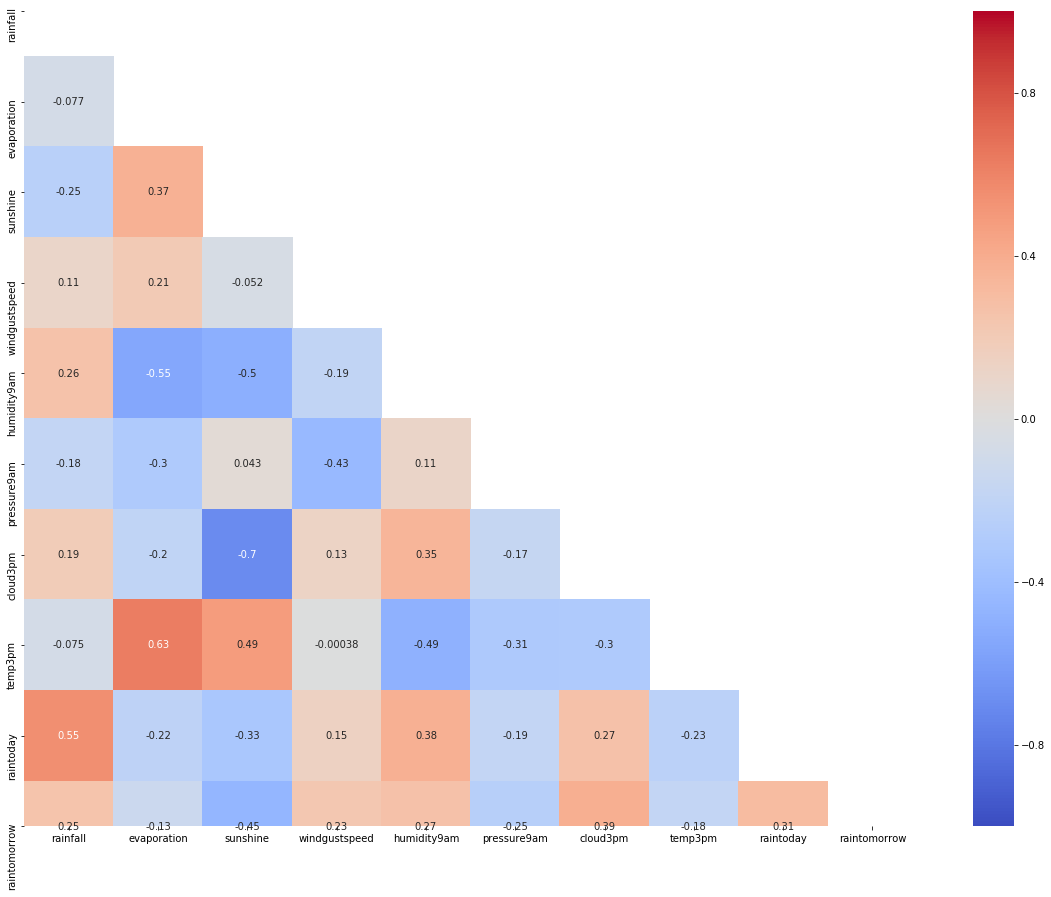

In [80]:
f, ax = plt.subplots(figsize=(20, 15))
matrix = np.triu(df_test.drop(columns=['mintemp', 'maxtemp', 'temp9am', 'cloud9am', 'maxtemp', 'mintemp', 'pressure3pm','humidity3pm', 'windspeed9am', 'windspeed3pm']).corr())
sns.heatmap(df_test.drop(columns=['mintemp', 'maxtemp', 'temp9am', 'cloud9am', 'maxtemp', 'mintemp', 'pressure3pm','humidity3pm', 'windspeed9am', 'windspeed3pm']).corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

# Stop here, wait for meeting to proceed

Current goal is to use all columns possible and then use a feature selection algorithm embedded in my classification if possible.

In [81]:
df_test.shape

(56420, 23)

In [82]:
# df_test.drop(columns=['mintemp', 'maxtemp', 'temp9am', 'cloud9am', 'maxtemp', 'mintemp', 'pressure3pm',
#                      'humidity3pm']
df_test3 = df_test
# df_test3.drop(columns=['mintemp', 'maxtemp', 'temp9am', 'cloud9am',
#                       'maxtemp', 'mintemp', 'pressure3pm','humidity3pm', 'windspeed9am', 'windspeed3pm'], inplace=True)

In [85]:
df_test3.drop(columns=['windspeed9am', 'windspeed3pm'], axis=1, inplace=True)

Going to move forward with getting dummies for all. Now remember, there are 26 cities. This could become a mess.

In [87]:
df_test3.shape

(56420, 21)

In [46]:
df_test3 = pd.get_dummies(df_test3, drop_first=True)

In [47]:
print(df_test3.shape)
df_test3.head()

(56420, 59)


,rainfall,evaporation,sunshine,windgustspeed,humidity9am,pressure9am,cloud3pm,temp3pm,raintoday,raintomorrow,location_Brisbane,location_Cairns,location_Canberra,location_Cobar,location_CoffsHarbour,location_Darwin,location_Hobart,location_Melbourne,location_MelbourneAirport,location_Mildura,location_Moree,location_MountGambier,location_NorfolkIsland,location_Nuriootpa,location_Perth,location_PerthAirport,location_Portland,location_Sale,location_Sydney,location_SydneyAirport,location_Townsville,location_WaggaWagga,location_Watsonia,location_Williamtown,location_Woomera,windgustdir_N,windgustdir_NE,windgustdir_NW,windgustdir_S,windgustdir_SE,windgustdir_SW,windgustdir_W,winddir9am_N,winddir9am_NE,winddir9am_NW,winddir9am_S,winddir9am_SE,winddir9am_SW,winddir9am_W,winddir3pm_N,winddir3pm_NE,winddir3pm_NW,winddir3pm_S,winddir3pm_SE,winddir3pm_SW,winddir3pm_W,season_spring,season_summer,season_winter
0,0.0,12.0,12.3,48.0,20.0,1006.3,5.0,33.4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0.0,14.8,13.0,37.0,30.0,1012.9,1.0,27.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
2,0.0,10.8,10.6,46.0,42.0,1012.3,6.0,34.9,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,0.0,11.4,12.2,31.0,37.0,1012.7,5.0,35.6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0.0,11.2,8.4,35.0,19.0,1010.7,6.0,37.6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [313]:
# df_test.drop(columns=['mintemp', 'evaporation', 'temp9am', 'maxtemp', 'rainfall',
#                      'windspeed9am', 'windspeed3pm'], inplace=True)

In [316]:
# df_test.shape

(56420, 65)

Now I am down to a sizeable data frame with a good mix of what I feel are necessary predictors, both categorical and continuous. I am still thinking about binning the cities by region and reducing the size impact dummying 26 cities causes. But we'll see.

In [146]:
y = df_test3['raintomorrow']
X = df_test3.drop(columns=['raintomorrow'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

In [147]:
# # Normalize the data
X_train_s = minmax.fit_transform(X_train)
X_test_s = minmax.fit_transform(X_test)
X_train_s = pd.DataFrame(X_train_s, columns=X_train.columns)
X_test_s = pd.DataFrame(X_test_s, columns=X_test.columns)

In [93]:
X_train_s

,rainfall,evaporation,sunshine,windgustspeed,humidity9am,pressure9am,cloud3pm,temp3pm,raintoday,location_Brisbane,location_Cairns,location_Canberra,location_Cobar,location_CoffsHarbour,location_Darwin,location_Hobart,location_Melbourne,location_MelbourneAirport,location_Mildura,location_Moree,location_MountGambier,location_NorfolkIsland,location_Nuriootpa,location_Perth,location_PerthAirport,location_Portland,location_Sale,location_Sydney,location_SydneyAirport,location_Townsville,location_WaggaWagga,location_Watsonia,location_Williamtown,location_Woomera,windgustdir_N,windgustdir_NE,windgustdir_NW,windgustdir_S,windgustdir_SE,windgustdir_SW,windgustdir_W,winddir9am_N,winddir9am_NE,winddir9am_NW,winddir9am_S,winddir9am_SE,winddir9am_SW,winddir9am_W,winddir3pm_N,winddir3pm_NE,winddir3pm_NW,winddir3pm_S,winddir3pm_SE,winddir3pm_SW,winddir3pm_W,season_spring,season_summer,season_winter
0,0.015519,0.174286,0.426573,0.617391,0.90,0.270451,0.666667,0.436321,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.002910,0.057143,0.643357,0.321739,0.84,0.582638,0.777778,0.382075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.141610,0.062857,0.104895,0.304348,0.87,0.654424,0.888889,0.507075,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.004850,0.037143,0.013986,0.278261,0.73,0.415693,0.777778,0.191038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.000000,0.157143,0.720280,0.295652,0.63,0.599332,0.333333,0.698113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42310,0.000000,0.091429,0.706294,0.278261,0.54,0.402337,0.444444,0.455189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
42311,0.004850,0.002857,0.293706,0.278261,0.81,0.759599,0.777778,0.132075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
42312,0.000000,0.020000,0.181818,0.052174,1.00,0.727880,0.777778,0.240566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42313,0.003880,0.154286,0.762238,0.356522,0.79,0.527546,0.666667,0.415094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Data is prepared, time to fit a model.

In [54]:
logreg = LogisticRegression()
penalty = ['l1', 'l2']
C = np.logspace(0,4,10)
hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(logreg, hyperparameters, cv=5)
model = clf.fit(X_train_s, y_train)
y_train_prediction = model.predict(X_train_s)
y_test_prediction = model.predict(X_test_s)


In [55]:
print('Best Penalty:', model.best_estimator_.get_params()['penalty'])
print('Best C:', model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 1.0


In [88]:
logreg_best = LogisticRegression(penalty='l2', C=1.0, random_state=42)
model_best_LR = logreg_best.fit(X_train_s, y_train)
y_train_prediction = model_best_LR.predict(X_train_s)
y_test_prediction = model_best_LR.predict(X_test_s)

In [94]:
print(y_train_prediction)
print(y_test_prediction)

[1 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]


In [95]:
print(classification_report(y_test, y_test_prediction))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90     11018
           1       0.63      0.60      0.62      3087

    accuracy                           0.84     14105
   macro avg       0.76      0.75      0.76     14105
weighted avg       0.83      0.84      0.83     14105



In [96]:
te_fpr, te_tpr, te_thresholds = roc_curve(y_test, y_test_prediction)
te_roc_auc = auc(te_fpr, te_tpr)
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_train, y_train_prediction)
tr_roc_auc = auc(tr_fpr, tr_tpr)

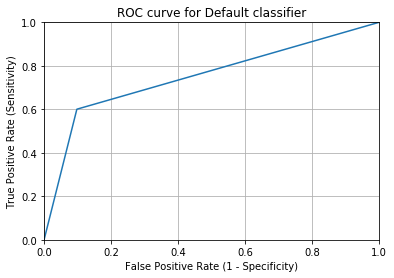

In [98]:
te_fpr, te_tpr, te_thresholds = roc_curve(y_test, y_test_prediction)
plt.plot(te_fpr, te_tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Default classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

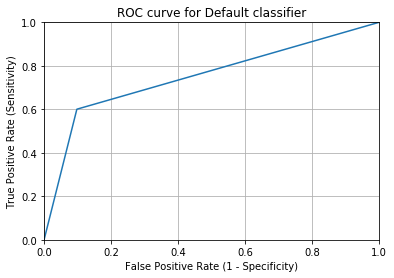

In [99]:
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_test, y_test_prediction)
plt.plot(tr_fpr, tr_tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Default classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [103]:
print('Test FPR:', te_fpr)
print('Test TPR:', te_tpr)
print('Test AUC:', te_roc_auc)
print('Test Accuracy:', accuracy_score(y_test, y_test_prediction))
print('Test Recall:', recall_score(y_test, y_test_prediction))
print('Test Precision:', precision_score(y_test, y_test_prediction))
print('Test F1:', f1_score(y_test, y_test_prediction))

Test FPR: [0.         0.09793066 1.        ]
Test TPR: [0.         0.60058309 1.        ]
Test AUC: 0.7513262157286221
Test Accuracy: 0.8360864941510103
Test Recall: 0.6005830903790087
Test Precision: 0.6321172860552335
Test F1: 0.6159468438538205


In [191]:
print(model_best_LR.score(X_test_s, y_test))
print(model_best_LR.score(X_train_s, y_train))

ValueError: X has 20 features per sample; expecting 58

---

## Going to try a RandomForest

For RandomForest, I need to reconfigure my data. All of my dummies need to be reversed and any categorical data needs to have one column with a numerical naming scheme such that its 1,2,3,4 in replace for the names.

In [106]:
df_rr = df_test
df_rr

,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,season
0,Cobar,17.9,35.2,0.0,12.0,12.3,SW,48.0,NE,SW,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0,summer
1,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SE,SE,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0,summer
2,Cobar,19.4,37.6,0.0,10.8,10.6,NE,46.0,NE,NW,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0,summer
3,Cobar,21.9,38.4,0.0,11.4,12.2,NW,31.0,NW,SW,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0,summer
4,Cobar,24.2,41.0,0.0,11.2,8.4,NW,35.0,NW,NW,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0,summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56415,Darwin,19.3,33.4,0.0,6.0,11.0,NE,35.0,SE,NE,63.0,32.0,1013.9,1010.5,0.0,1.0,24.5,32.3,0,0,winter
56416,Darwin,21.2,32.6,0.0,7.6,8.6,E,37.0,SE,SE,56.0,28.0,1014.6,1011.2,7.0,0.0,24.8,32.0,0,0,winter
56417,Darwin,20.7,32.8,0.0,5.6,11.0,E,33.0,E,W,46.0,23.0,1015.3,1011.8,0.0,0.0,24.8,32.1,0,0,winter
56418,Darwin,19.5,31.8,0.0,6.2,10.6,SE,26.0,SE,NW,62.0,58.0,1014.9,1010.7,1.0,1.0,24.8,29.2,0,0,winter


In [108]:
df_rr.columns

Index(['location', 'mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine',
       'windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm',
       'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am',
       'cloud3pm', 'temp9am', 'temp3pm', 'raintoday', 'raintomorrow',
       'season'],
      dtype='object')

In [114]:
list(set(df_rr['location'].values))


['Canberra',
 'Hobart',
 'WaggaWagga',
 'SydneyAirport',
 'Woomera',
 'Sale',
 'PerthAirport',
 'Brisbane',
 'Mildura',
 'Nuriootpa',
 'Sydney',
 'Watsonia',
 'Townsville',
 'CoffsHarbour',
 'MountGambier',
 'Melbourne',
 'Moree',
 'Darwin',
 'Williamtown',
 'AliceSprings',
 'Portland',
 'MelbourneAirport',
 'NorfolkIsland',
 'Perth',
 'Cobar',
 'Cairns']

In [117]:
# Turning all of the unique values into a number
df_rr['location'] = pd.factorize(df_rr['location'])[0] + 1

In [116]:
df_rr

,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,season
0,1,17.9,35.2,0.0,12.0,12.3,SW,48.0,NE,SW,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0,summer
1,1,18.4,28.9,0.0,14.8,13.0,S,37.0,SE,SE,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0,summer
2,1,19.4,37.6,0.0,10.8,10.6,NE,46.0,NE,NW,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0,summer
3,1,21.9,38.4,0.0,11.4,12.2,NW,31.0,NW,SW,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0,summer
4,1,24.2,41.0,0.0,11.2,8.4,NW,35.0,NW,NW,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0,summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56415,26,19.3,33.4,0.0,6.0,11.0,NE,35.0,SE,NE,63.0,32.0,1013.9,1010.5,0.0,1.0,24.5,32.3,0,0,winter
56416,26,21.2,32.6,0.0,7.6,8.6,E,37.0,SE,SE,56.0,28.0,1014.6,1011.2,7.0,0.0,24.8,32.0,0,0,winter
56417,26,20.7,32.8,0.0,5.6,11.0,E,33.0,E,W,46.0,23.0,1015.3,1011.8,0.0,0.0,24.8,32.1,0,0,winter
56418,26,19.5,31.8,0.0,6.2,10.6,SE,26.0,SE,NW,62.0,58.0,1014.9,1010.7,1.0,1.0,24.8,29.2,0,0,winter


In [119]:
# Going to do the same for any column that is categorical
df_rr['windgustdir'] = pd.factorize(df_rr['windgustdir'])[0] + 1
df_rr['winddir9am'] = pd.factorize(df_rr['winddir9am'])[0] + 1
df_rr['winddir3pm'] = pd.factorize(df_rr['winddir3pm'])[0] + 1
df_rr['season'] = pd.factorize(df_rr['season'])[0] + 1

In [120]:
df_rr

,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,season
0,1,17.9,35.2,0.0,12.0,12.3,1,48.0,1,1,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0,1
1,1,18.4,28.9,0.0,14.8,13.0,2,37.0,2,2,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0,1
2,1,19.4,37.6,0.0,10.8,10.6,3,46.0,1,3,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0,1
3,1,21.9,38.4,0.0,11.4,12.2,4,31.0,3,1,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0,1
4,1,24.2,41.0,0.0,11.2,8.4,4,35.0,3,3,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56415,26,19.3,33.4,0.0,6.0,11.0,3,35.0,2,5,63.0,32.0,1013.9,1010.5,0.0,1.0,24.5,32.3,0,0,3
56416,26,21.2,32.6,0.0,7.6,8.6,7,37.0,2,2,56.0,28.0,1014.6,1011.2,7.0,0.0,24.8,32.0,0,0,3
56417,26,20.7,32.8,0.0,5.6,11.0,7,33.0,8,8,46.0,23.0,1015.3,1011.8,0.0,0.0,24.8,32.1,0,0,3
56418,26,19.5,31.8,0.0,6.2,10.6,6,26.0,2,3,62.0,58.0,1014.9,1010.7,1.0,1.0,24.8,29.2,0,0,3


I think my data is ready to be run through a RandomForest classifier.  
Going to make a base model now.

In [153]:
rf = RandomForestClassifier(random_state = 42, criterion='gini')
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())


Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [154]:
X_train, X_test, y_train, y_test = train_test_split(df_rr.drop(columns=['raintomorrow'], axis=1),
                                                   df_rr['raintomorrow'], test_size=0.2, random_state=42)


### Keep in mind this first run is on un-scaled data.

In [156]:
rr_mod1 = rf.fit(X_train, y_train)
base_train_prediction = rr_mod1.predict(X_train)
base_test_prediction = rr_mod1.predict(X_test)

In [158]:
print(classification_report(y_test, base_test_prediction))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      8799
           1       0.76      0.49      0.59      2485

    accuracy                           0.85     11284
   macro avg       0.81      0.72      0.75     11284
weighted avg       0.84      0.85      0.84     11284



In [159]:
te_fpr, te_tpr, te_thresholds = roc_curve(y_test, base_test_prediction)
te_roc_auc = auc(te_fpr, te_tpr)
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_train, base_train_prediction)
tr_roc_auc = auc(tr_fpr, tr_tpr)

In [160]:
print('Test FPR:', te_fpr)
print('Test TPR:', te_tpr)
print('Test AUC:', te_roc_auc)
print('Test Accuracy:', accuracy_score(y_test, base_test_prediction))
print('Test Recall:', recall_score(y_test, base_test_prediction))
print('Test Precision:', precision_score(y_test, base_test_prediction))
print('Test F1:', f1_score(y_test, base_test_prediction))

Test FPR: [0.         0.04443687 1.        ]
Test TPR: [0.         0.48973843 1.        ]
Test AUC: 0.7226507813788059
Test Accuracy: 0.8529776674937966
Test Recall: 0.489738430583501
Test Precision: 0.7568407960199005
Test F1: 0.5946738333740532


Overall it doesn't seem to be that my RandomForest Classifier was substantially better or worse, but I am looking to refine this model and see what we can do.

In [162]:
# Creating some preliminary hyperparameters

# Number of trees in random forest
n_estimators = [10,100,200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2', None]
# Maximum number of levels in tree
max_depth =[2,5,10]
max_depth.append(None)
# Minimum number of samples required to split a node
None
# Minimum number of samples required at each leaf node
None
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
pprint(param_grid)

{'bootstrap': [True, False],
 'max_depth': [2, 5, 10, None],
 'max_features': ['auto', 'sqrt', 'log2', None],
 'n_estimators': [10, 100, 200]}


In [163]:
rf = RandomForestClassifier(random_state = 42)
# Instantiate the grid search model
# Have to tell it which model "estimator" you wanna use
# input your parameter grid
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [164]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'n_estimators': 100}

In [165]:
rf_refined = RandomForestClassifier(random_state=42, bootstrap=False, max_depth=None, max_features= 'auto',
                                   n_estimators=100)
rf_refined.fit(X_train, y_train)
ref_train_pred = rf_refined.predict(X_train)
ref_test_pred = rf_refined.predict(X_test)


In [169]:
te_fpr, te_tpr, te_thresholds = roc_curve(y_test, ref_test_pred)
te_roc_auc = auc(te_fpr, te_tpr)
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_train, ref_train_pred)
tr_roc_auc = auc(tr_fpr, tr_tpr)

In [171]:
print(classification_report(y_test, ref_test_pred))
print('Test FPR:', te_fpr)
print('Test TPR:', te_tpr)
print('Test AUC:', te_roc_auc)
print('Test Accuracy:', accuracy_score(y_test, ref_test_pred))
print('Test Recall:', recall_score(y_test, ref_test_pred))
print('Test Precision:', precision_score(y_test, ref_test_pred))
print('Test F1:', f1_score(y_test, ref_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      8799
           1       0.77      0.55      0.64      2485

    accuracy                           0.86     11284
   macro avg       0.83      0.75      0.78     11284
weighted avg       0.86      0.86      0.86     11284

Test FPR: [0.         0.04614161 1.        ]
Test TPR: [0.         0.54647887 1.        ]
Test AUC: 0.7501686331193206
Test Accuracy: 0.8641439205955335
Test Recall: 0.5464788732394367
Test Precision: 0.7698412698412699
Test F1: 0.6392092257001648


In [186]:
rf_refined.score(X_test, y_test)

0.8641439205955335

In [189]:
rf_refined.score(X_train, y_train)

1.0

---

## Second Hyperparameter Tuning Grid

In [176]:
# Number of trees in random forest
n_estimators = [10,50,100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2', None]
# Maximum number of levels in tree
max_depth =[10,25]
# Minimum number of samples required to split a node
mss = [3, 20, 40]
# Minimum number of samples required at each leaf node
msl = [4, 10]
# Method of selecting samples for training each tree
bootstrap = [True]
# criterion
criterion = ['gini', 'entropy']
# oob score
os = [True]
# cores to use
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap,
              'min_samples_split': mss,
              'min_samples_leaf': msl,
              'oob_score': os,
              'criterion': criterion
             }
pprint(param_grid)

{'bootstrap': [True],
 'criterion': ['gini', 'entropy'],
 'max_depth': [10, 25],
 'max_features': ['auto', 'sqrt', 'log2', None],
 'min_samples_leaf': [4, 10],
 'min_samples_split': [3, 20, 40],
 'n_estimators': [10, 50, 100],
 'oob_score': [True]}


In [177]:
rf_3 = RandomForestClassifier(random_state = 42)
# Instantiate the grid search model
# Have to tell it which model "estimator" you wanna use
# input your parameter grid
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap': [True]

In [178]:
grid_search.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 25,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 100,
 'oob_score': True}

In [182]:
rf2_refined = RandomForestClassifier(random_state=42,bootstrap= True,criterion= 'gini',max_depth= 25,
                                     max_features= 'auto',min_samples_leaf= 4,min_samples_split= 3,
                                     n_estimators= 100,oob_score= True)
rf2_refined.fit(X_train, y_train)
ref2_train_pred = rf2_refined.predict(X_train)
ref2_test_pred = rf2_refined.predict(X_test)

In [183]:
te_fpr, te_tpr, te_thresholds = roc_curve(y_test, ref2_test_pred)
te_roc_auc = auc(te_fpr, te_tpr)
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_train, ref2_train_pred)
tr_roc_auc = auc(tr_fpr, tr_tpr)

In [184]:
print(classification_report(y_test, ref2_test_pred))
print('Test FPR:', te_fpr)
print('Test TPR:', te_tpr)
print('Test AUC:', te_roc_auc)
print('Test Accuracy:', accuracy_score(y_test, ref2_test_pred))
print('Test Recall:', recall_score(y_test, ref2_test_pred))
print('Test Precision:', precision_score(y_test, ref2_test_pred))
print('Test F1:', f1_score(y_test, ref2_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      8799
           1       0.77      0.53      0.63      2485

    accuracy                           0.86     11284
   macro avg       0.82      0.74      0.77     11284
weighted avg       0.85      0.86      0.85     11284

Test FPR: [0.         0.04420957 1.        ]
Test TPR: [0.         0.52837022 1.        ]
Test AUC: 0.7420803260293662
Test Accuracy: 0.8616625310173698
Test Recall: 0.5283702213279678
Test Precision: 0.7714453584018801
Test F1: 0.6271793647002628


In [185]:
rf2_refined.score(X_test, y_test)

0.8616625310173698

In [187]:
rf2_refined.score(X_train, y_train)

0.9468716767103864